<a href="https://colab.research.google.com/github/asdsadadad/BasicSR/blob/master/Sprite_Generator_v0_6_by_Hotgrits_on_EleutherAI_simplified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Oct  6 00:46:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Run this (you only need to do this once per session)


In [2]:
!curl -L -o sprite_generator_v06_6.pt -C - 'https://cdn.discordapp.com/attachments/730484623028519072/867593206220718112/sprite_generator_v06_7-21-2021_7.pt'
!pip -qq install torch_optimizer
!pip -qq install av
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch_optimizer as optim
import PIL
from PIL import Image
import random
import math
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(False)

def clear_mem():
    torch.cuda.empty_cache()
    gc.collect()

ToTensor = T.ToTensor()
ToImage  = T.ToPILImage()

def OpenImage(x, resize=None, convert="RGB"):
    if resize:
        return ToTensor(Image.open(x).convert(convert).resize(resize)).unsqueeze(0).to(device)
    else:
        return ToTensor(Image.open(x).convert(convert)).unsqueeze(0).to(device)

def diff_abs(x, y=0.0001):
    return torch.sqrt(x*x+y)

def diff_relu(x, y=0.0001):
    return (torch.sqrt(x*x+y)+x)*0.5

def diff_clamp(x, y=0.0001):
    return diff_relu(1-diff_relu(1-x, y), y)

class PixelNet(torch.nn.Module):
    def __init__(self):
        super(PixelNet, self).__init__()

        self.enc_layers_0 = nn.Sequential(
                              nn.Conv2d( 1,  8, 2, 2, 0),
                              nn.Conv2d( 8, 16, 2, 2, 0),
                              nn.Conv2d(16, 32, 2, 2, 0),
                        )

        self.batchnorm = nn.InstanceNorm2d(32)

        self.lin_layers = nn.Sequential(
                              nn.Conv2d(32, 64, 3, 1, 1),
                              nn.BatchNorm2d(64),
                              nn.GELU(),
                              nn.Conv2d(64, 64, 3, 1, 1),
                              nn.BatchNorm2d(64),
                              nn.GELU(),
                              nn.Conv2d(64, 32, 3, 1, 1),
                              nn.BatchNorm2d(32),
                          )

        self.cnn_layers = nn.Sequential(
                              nn.Conv2d(32, 32, 3, 1, 1),      
                              nn.ConvTranspose2d(32, 16, 2, 2),
                              nn.Conv2d(16, 32, 3, 1, 1),      
                              nn.BatchNorm2d(32),              
                              nn.GELU(),                       
                              nn.ConvTranspose2d(32, 16, 2, 2),
                              nn.Conv2d(16, 32, 3, 1, 1),      
                              nn.BatchNorm2d(32),              
                              nn.GELU(),                       
                              nn.ConvTranspose2d(32, 16, 2, 2),
                              nn.Conv2d(16, 4, 3, 1, 1),       
                          )

        self.palette = torch.tensor([[0.0, 0.333, 0.667, 1.0]]).T.to(device)

    def encode(self, x):
        x = self.enc_layers_0(x)
        return x

    def decode(self, x, y=25, batchnorm=True, dropout_p=0):
        if dropout_p == 0:
            dropout = nn.Identity()
        else:
            dropout = nn.AlphaDropout(dropout_p)
        if batchnorm == True:
            x = self.batchnorm(x)
        # x = self.lin_layers(x)
        # x = self.cnn_layers(x)
        x = self.lin_layers[:3](x)
        x = dropout(x)
        x = self.lin_layers[3:6](x)
        x = self.lin_layers[6:](x)
        x = dropout(x)
        x = self.cnn_layers[0](x)
        x = dropout(x)
        x = self.cnn_layers[1:](x)
        x = (x.permute(0,2,3,1).mul(y).softmax(-1) @ self.palette).permute(0,3,1,2)
        return x

    def forward(self, x, y=25):
        x = self.encode(x)
        x = self.decode(x, y)
        return x

model = PixelNet().to(device)

# model(torch.rand(8,1,56,56).to(device)).shape

model.load_state_dict(torch.load("/content/sprite_generator_v06_6.pt"))
model.eval();
!pip install --no-deps git+https://github.com/openai/CLIP.git
!pip install --no-deps ftfy regex tqdm

import clip
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(False)

perceptor, preprocess = clip.load("ViT-B/32", jit=False)
perceptor.eval().float().requires_grad_(False);

CLIP_Normalization = T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))





  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  416k  100  416k    0     0  1375k      0 --:--:-- --:--:-- --:--:-- 1371k
     |████████████████████████████████| 72 kB 515 kB/s 
     |████████████████████████████████| 37.2 MB 31 kB/s 
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-lk5y75d1
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-lk5y75d1
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369090 sha256=9ad51f0e5215d09725256107c0e8693c587b0089d095ad670c3faa7e08eebdad
  Stored in directory: /tmp/pip-ephem-wheel-cache-i00xrp5s/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip
     |████████████████████████████████| 64 kB 1.9 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=85fd8caed418b4fe488763c5d82e90f5dc2320aea277c4b

100%|███████████████████████████████████████| 338M/338M [00:17<00:00, 20.3MiB/s]


## Generate the image

Set the prompt

In [7]:
prompt = perceptor.encode_text(clip.tokenize(["Metal Gear Solid"]).to(device)).mean(0,True)

Or use an image as a prompt instead

In [4]:
prompt_img = OpenImage("flickr_dog_000137.jpg", (224,224)).tile(8,1,1,1)
prompt_img += torch.randn_like(prompt_img) * 0.025
prompt = perceptor.encode_image(CLIP_Normalization(prompt_img)).mean(0,True)

FileNotFoundError: ignored

Then press Play here to generate

0 0.8090600371360779


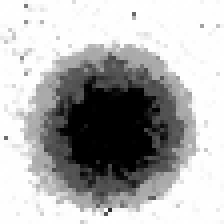

100 0.6680757999420166


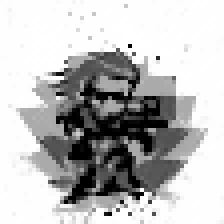

200 0.6427553296089172


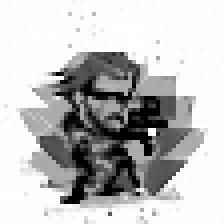

In [ ]:
# Vignettes for init images and masking noise
vig = torch.cat(torch.meshgrid(2*[torch.linspace(-1,1,64)])).reshape(2,64,64).pow(2).sum(0,True).mul(2).sub(0).clamp(0,1).to(device)
vig = TF.crop(vig, 0, 4, 56, 56).unsqueeze(0)
vig_7x7 = torch.cat(torch.meshgrid(2*[torch.linspace(-1,1,9)])).reshape(2,9,9).pow(2).sum(0,True).mul(3).sub(1).clamp(0,1).to(device)
vig_7x7 = 1 - TF.crop(vig_7x7, 0, 1, 7, 7)

blank_image = model.encode(vig - torch.rand_like(vig) * 0.333)
blank_image = model.batchnorm(blank_image) # The encoder's values are huge due to the batchnorm being in the decoder section, but for easier optimization batchnorm it first.
clip_root = blank_image.clone().detach() + torch.randn((1,32,7,7)).to(device).mul(vig_7x7) * 0.25
clip_root = clip_root.requires_grad_(True)
clip_optimizer = optim.Yogi([clip_root], lr=1/8, weight_decay=0.00)

video_frames = None

torch.set_grad_enabled(True)
model.eval()

vig = torch.cat(torch.meshgrid(2*[torch.linspace(-1,1,64)])).reshape(2,64,64).pow(2).sum(0,True).mul(3).sub(1).clamp(0,1).pow(2).to(device)
vig = TF.crop(vig, 0, 4, 56, 56)

laplacian_kernel = torch.tensor([
    [.05, .2, .05],
    [ .2, -1, .2 ],
    [.05, .2, .05]
]).unsqueeze(0).unsqueeze(0).to(device)

def laplacian_filter(x):
    b, c, h, w = x.shape
    x = x.reshape(b*c, 1, h, w)
    x = F.pad(x, [2,2,2,2], mode='reflect')
    x = F.conv2d(x, laplacian_kernel)
    x = TF.pad(x, -1)
    b2, c2, h2, w2 = x.shape
    x = x.reshape(b, c, h2, w2)
    return x

def white_background_check(x):
    x = 1 - x
    x = x * vig
    x_mean = x.mean()
    x_std = x.std()
    return x_mean + x_std

def sneaky_round(x):
    new_x = x
    with torch.no_grad():
      new_x[:] = x.mul(3).round().div(3)
    return new_x

augments = T.Compose([
        T.RandomChoice([
            T.Resize((224,224), T.InterpolationMode.NEAREST),
            T.Resize((224,224), T.InterpolationMode.BILINEAR),
            T.Resize((240,224), T.InterpolationMode.NEAREST),
            T.Resize((240,224), T.InterpolationMode.BILINEAR),
            T.Resize((256,224), T.InterpolationMode.NEAREST),
            T.Resize((256,224), T.InterpolationMode.BILINEAR),
            T.Resize((224,240), T.InterpolationMode.NEAREST),
            T.Resize((224,240), T.InterpolationMode.BILINEAR),
            T.Resize((224,256), T.InterpolationMode.NEAREST),
            T.Resize((224,256), T.InterpolationMode.BILINEAR),
        ]),
        T.Pad(64, fill=1.0),
        T.RandomRotation(15, T.InterpolationMode.BILINEAR),
        T.Pad(-56),
        T.RandomChoice([
            T.Lambda(lambda x: TF.gaussian_blur(x, 7, 2.55)),
            T.Lambda(lambda x: TF.gaussian_blur(x, 5, 1.27)),
            T.Lambda(lambda x: TF.gaussian_blur(x, 3, 0.64)),
            T.Lambda(lambda x: x),
        ]),
        T.Lambda(lambda x: x + torch.rand(1,).item() * 0.2 - 0.1),
        T.Lambda(lambda x: x * (torch.rand(1,).item() * 0.3 + 0.85)),
        T.RandomCrop((224,224)),
        T.Lambda(lambda x: x + torch.randn_like(x).mul(0.02)),
        T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

gentle_augments = T.Compose([
        T.RandomChoice([
            T.Resize((224,224), T.InterpolationMode.NEAREST),
            T.Resize((224,224), T.InterpolationMode.BILINEAR),
        ]),
        T.Pad(16, fill=1.0),
        T.RandomRotation(2, T.InterpolationMode.BILINEAR),
        T.Pad(-12),
        T.RandomChoice([
            T.Lambda(lambda x: TF.gaussian_blur(x, 7, 2.55)),
            T.Lambda(lambda x: TF.gaussian_blur(x, 5, 1.27)),
            T.Lambda(lambda x: TF.gaussian_blur(x, 3, 0.64)),
            T.Lambda(lambda x: x),
        ]),
        T.Lambda(lambda x: x + torch.rand(1,).item() * 0.2 - 0.1),
        T.Lambda(lambda x: x * (torch.rand(1,).item() * 0.3 + 0.85)),
        T.RandomCrop((224,224)),
        T.Lambda(lambda x: x + torch.randn_like(x).mul(0.02)),
        T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
])

for i in range(500):
    x = model.decode(clip_root)
    x_color = x.tile(1,3,1,1)

    with torch.no_grad(): #This is just preparing frames for the video. It stores them in ram, not gpu memory, so it shouldn't impact much.
        x_color_big = TF.resize(x_color, (112,112), T.InterpolationMode.NEAREST)
        x_color_big = F.interpolate(x_color_big, (224,224), mode='bicubic', align_corners=False)
        if video_frames == None:
            video_frames = (x_color_big.permute(0,2,3,1).clamp(0,1)*255).byte().cpu()
        else:
            video_frames = torch.cat([video_frames, (x_color_big.permute(0,2,3,1).clamp(0,1)*255).byte().cpu()])

    x_aug = torch.cat([augments(x_color) for _ in range(16)])
    x_enc = perceptor.encode_image(x_aug)
    comparisons = 1.0 - torch.cosine_similarity(prompt, x_enc, -1)
    loss  = torch.mean(comparisons)
    loss += (x - torch.round(x*3).div(3)).pow(2).mean() * 0.25
    loss += white_background_check(x).mul(2).pow(2) * 0.25
    loss += laplacian_filter(x).mean().pow(4)
    with torch.no_grad():
        loss.backward()
        # clip_root.grad = TF.gaussian_blur(clip_root.grad, 3) * 0.25 + clip_root.grad * 0.75
        clip_root.grad /= clip_root.grad.norm().add(1e-8)
        clip_optimizer.step()
        clip_optimizer.zero_grad()
        if i % 100 == 0:
            print(i, loss.item())
            display(ToImage(x.clamp(0,1)[0]).resize((224,224),0))

x = model.decode(clip_root)
display(ToImage(x.clamp(0,1)[0]).resize((224,224),0))

Write video of generation process

In [ ]:
torchvision.io.write_video("lr_100.mp4", video_frames, fps=15, options={'crf': '30'})